# [Catastrophic Overfitting Papers](https://ramtinmoslemi.github.io/Catastrophic-Overfitting-Papers/)

A complete list of papers on **Fast Adversarial Training** and **Catastrophic Overfitting**.
You can find the papers and their titles, abstracts, authors, links, and dates stored in [this csv file](https://github.com/RamtinMoslemi/Catastrophic-Overfitting-Papers/blob/main/co_papers.csv).




[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RamtinMoslemi/Catastrophic-Overfitting-Papers/blob/main/CO_Papers.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/RamtinMoslemi/Catastrophic-Overfitting-Papers/main/CO_Papers.ipynb)

In [1]:
import re
import requests
import textwrap
import requests
import pandas as pd
import seaborn as sns
import concurrent.futures
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# Extracting from arXiv

In [2]:
# @title Get papers from arXiv

month_converter = {"01": "January", "02": "February", "03": "March",
                   "04": "April", "05": "May", "06": "June",
                   "07": "July", "08": "August", "09": "September",
                   "10": "October", "11": "November", "12": "December"}

# Extracted from Carlini
false_positives = ['https://arxiv.org/abs/2206.02355',
                   'https://arxiv.org/abs/2306.13185',
                   'https://arxiv.org/abs/2402.01297',
                   'https://arxiv.org/abs/2404.16612',
                   'https://arxiv.org/abs/2503.18998']


tag_info = {}


def get_page_papers(soup):
    global tag_info
    page_papers = []

    # Find all paper entries
    paper_entries = soup.find_all('li', {'class': 'arxiv-result'})

    for entry in paper_entries:
        # Extract paper title
        title_tag = entry.find('p', {'class': 'title is-5 mathjax'})
        title = title_tag.text.strip() if title_tag else 'No Title Found'

        # Extract abstract link
        link_tag = entry.find('a', href=True)
        abstract_link = link_tag['href'] if link_tag else 'No Link Found'

        # Extract tags
        tag_tag = entry.find_all('span', {'class': 'tag is-small is-link tooltip is-tooltip-top'})
        tag_tag += entry.find_all('span', {'class': 'tag is-small is-grey tooltip is-tooltip-top'})
        tag = []
        for i in range(len(tag_tag)):
            try:
                t = tag_tag[i].text.strip()
                tag.append(t)
                tag_info[t] = tag_tag[i]['data-tooltip']
            except:
                continue
        tag = ', '.join(tag) if len(tag) > 0 else 'No Tag Found'

        # Extract year and month from the link
        match = re.search(r'(\d{2})(\d{2})\.\d*', abstract_link)
        if match:
            year, month = str(20) + match.group(1), month_converter[match.group(2)]
        else:
            year, month = 'Unknown', 'Unknown'

        # Extract abstract text
        abstract_tag = entry.find('span', {'class': 'abstract-full has-text-grey-dark mathjax'})
        abstract = abstract_tag.text.replace('Abstract:', '').strip() if abstract_tag else "Abstract not found."
        if abstract.endswith('         △ Less'):
            abstract = abstract[:-len('         △ Less')]
        elif abstract.endswith(' △ Less'):
            abstract = abstract[:-len(' △ Less')]

        # Extract author names
        authors_tag = entry.find('p', {'class': 'authors'})
        author_names = []
        if authors_tag:
            author_tags = authors_tag.find_all('a')
            author_names = [author.text.strip() for author in author_tags]
        authors = ', '.join(author_names)

        if abstract_link in false_positives:
            continue
        page_papers.append({'Title': title, 'Abstract': abstract, 'Link': abstract_link, 'Tag': tag, 'Year': year, 'Month': month, 'Authors': authors})
    return page_papers


def extract_paper_info(search_keys=['fast adversarial training', 'catastrophic overfitting', 'single-step adversarial training', 'single-step defenses'], size=200):
    papers = []
    for search_key in search_keys:
        new_papers = []
        search_key = '+'.join(search_key.split())
        url = f'https://arxiv.org/search/?query=%22{search_key}%22&searchtype=all&abstracts=show&order=announced_date_first&size=200'
        while True:
            # Send a GET request to the search URL
            response = requests.get(url + f'&start={len(new_papers)}')
            soup = BeautifulSoup(response.content, 'html.parser')
            # Add paper from this page
            new_papers += get_page_papers(soup)
            # Stop on final page (must be fixed later)
            if len(new_papers) % size != 0:
                break

            print(new_papers)
        papers += new_papers
    return pd.DataFrame(papers).sort_values(by='Link').drop_duplicates(subset='Link', keep='first').reset_index(drop=True)


def get_citation_count(arxiv_id: str):
    url = f"https://api.semanticscholar.org/v1/paper/arXiv:{arxiv_id}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        venue = data.get("venue", "Unknown")
        if venue in ["arXiv.org", ""]:
            venue = "Unknown"
        return data.get("numCitedBy", 0), venue
    return 0, "Unknown"

In [3]:
papers = extract_paper_info()

arxiv_ids = [link.split("/")[-1] for link in papers["Link"]]
citations, venues = [], []

# Use multi-threading to fetch data in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(get_citation_count, arxiv_ids))

# Unpack results into lists
citations, venues = zip(*results)

papers['Citation Count'] = citations
papers['Venue'] = venues
papers.to_csv('co_papers.csv', index=False)
tag_info

{'cs.LG': 'Machine Learning',
 'cs.CV': 'Computer Vision and Pattern Recognition',
 'stat.ML': 'Machine Learning',
 'cs.CR': 'Cryptography and Security',
 'cs.AI': 'Artificial Intelligence',
 'eess.IV': 'Image and Video Processing',
 'cs.CL': 'Computation and Language'}

# Plots

In [4]:
df = pd.read_csv('co_papers.csv')
df

,Title,Abstract,Link,Tag,Year,Month,Authors,Citation Count,Venue
0,Adversarially Robust Distillation,Knowledge distillation is effective for produc...,https://arxiv.org/abs/1905.09747,"cs.LG, cs.CV, stat.ML",2019,May,"Micah Goldblum, Liam Fowl, Soheil Feizi, Tom G...",209,AAAI Conference on Artificial Intelligence
1,Fast is better than free: Revisiting adversari...,"Adversarial training, a method for learning ro...",https://arxiv.org/abs/2001.03994,"cs.LG, stat.ML",2020,January,"Eric Wong, Leslie Rice, J. Zico Kolter",1177,International Conference on Learning Represent...
2,Regularizers for Single-step Adversarial Training,The progress in the last decade has enabled ma...,https://arxiv.org/abs/2002.00614,"cs.LG, cs.CV",2020,February,"B. S. Vivek, R. Venkatesh Babu",7,Unknown
3,Using Single-Step Adversarial Training to Defe...,Adversarial examples have become one of the la...,https://arxiv.org/abs/2002.09632,"cs.LG, cs.CR, stat.ML",2020,February,"Guanxiong Liu, Issa Khalil, Abdallah Khreishah",19,Conference on Data and Application Security an...
4,Single-step Adversarial training with Dropout ...,Deep learning models have shown impressive per...,https://arxiv.org/abs/2004.08628,"cs.LG, cs.CV",2020,April,"Vivek B. S., R. Venkatesh Babu",72,Computer Vision and Pattern Recognition
...,...,...,...,...,...,...,...,...,...
59,RoMA: Robust Malware Attribution via Byte-leve...,Attributing APT (Advanced Persistent Threat) m...,https://arxiv.org/abs/2502.07492,"cs.CR, cs.CV",2025,February,"Yuxia Sun, Huihong Chen, Jingcai Guo, Aoxiang ...",0,Unknown
60,Fast Adversarial Training against Sparse Attac...,This paper studies fast adversarial training a...,https://arxiv.org/abs/2502.21041,"cs.LG, cs.AI",2025,February,"Xuyang Zhong, Yixiao Huang, Chen Liu",0,Unknown
61,Fast Adversarial Training with Weak-to-Strong ...,Adversarial Training (AT) has been shown to si...,https://arxiv.org/abs/2504.14921,"cs.CV, cs.AI",2025,April,"Songping Wang, Hanqing Liu, Yueming Lyu, Xiant...",0,Unknown
62,"Catastrophic Overfitting, Entropy Gap and Part...",Adversarial training is a cornerstone of robus...,https://arxiv.org/abs/2505.02360,"cs.LG, cs.AI",2025,May,"Fares B. Mehouachi, Saif Eddin Jabari",0,Unknown


Number of papers submitted to arXiv each year.

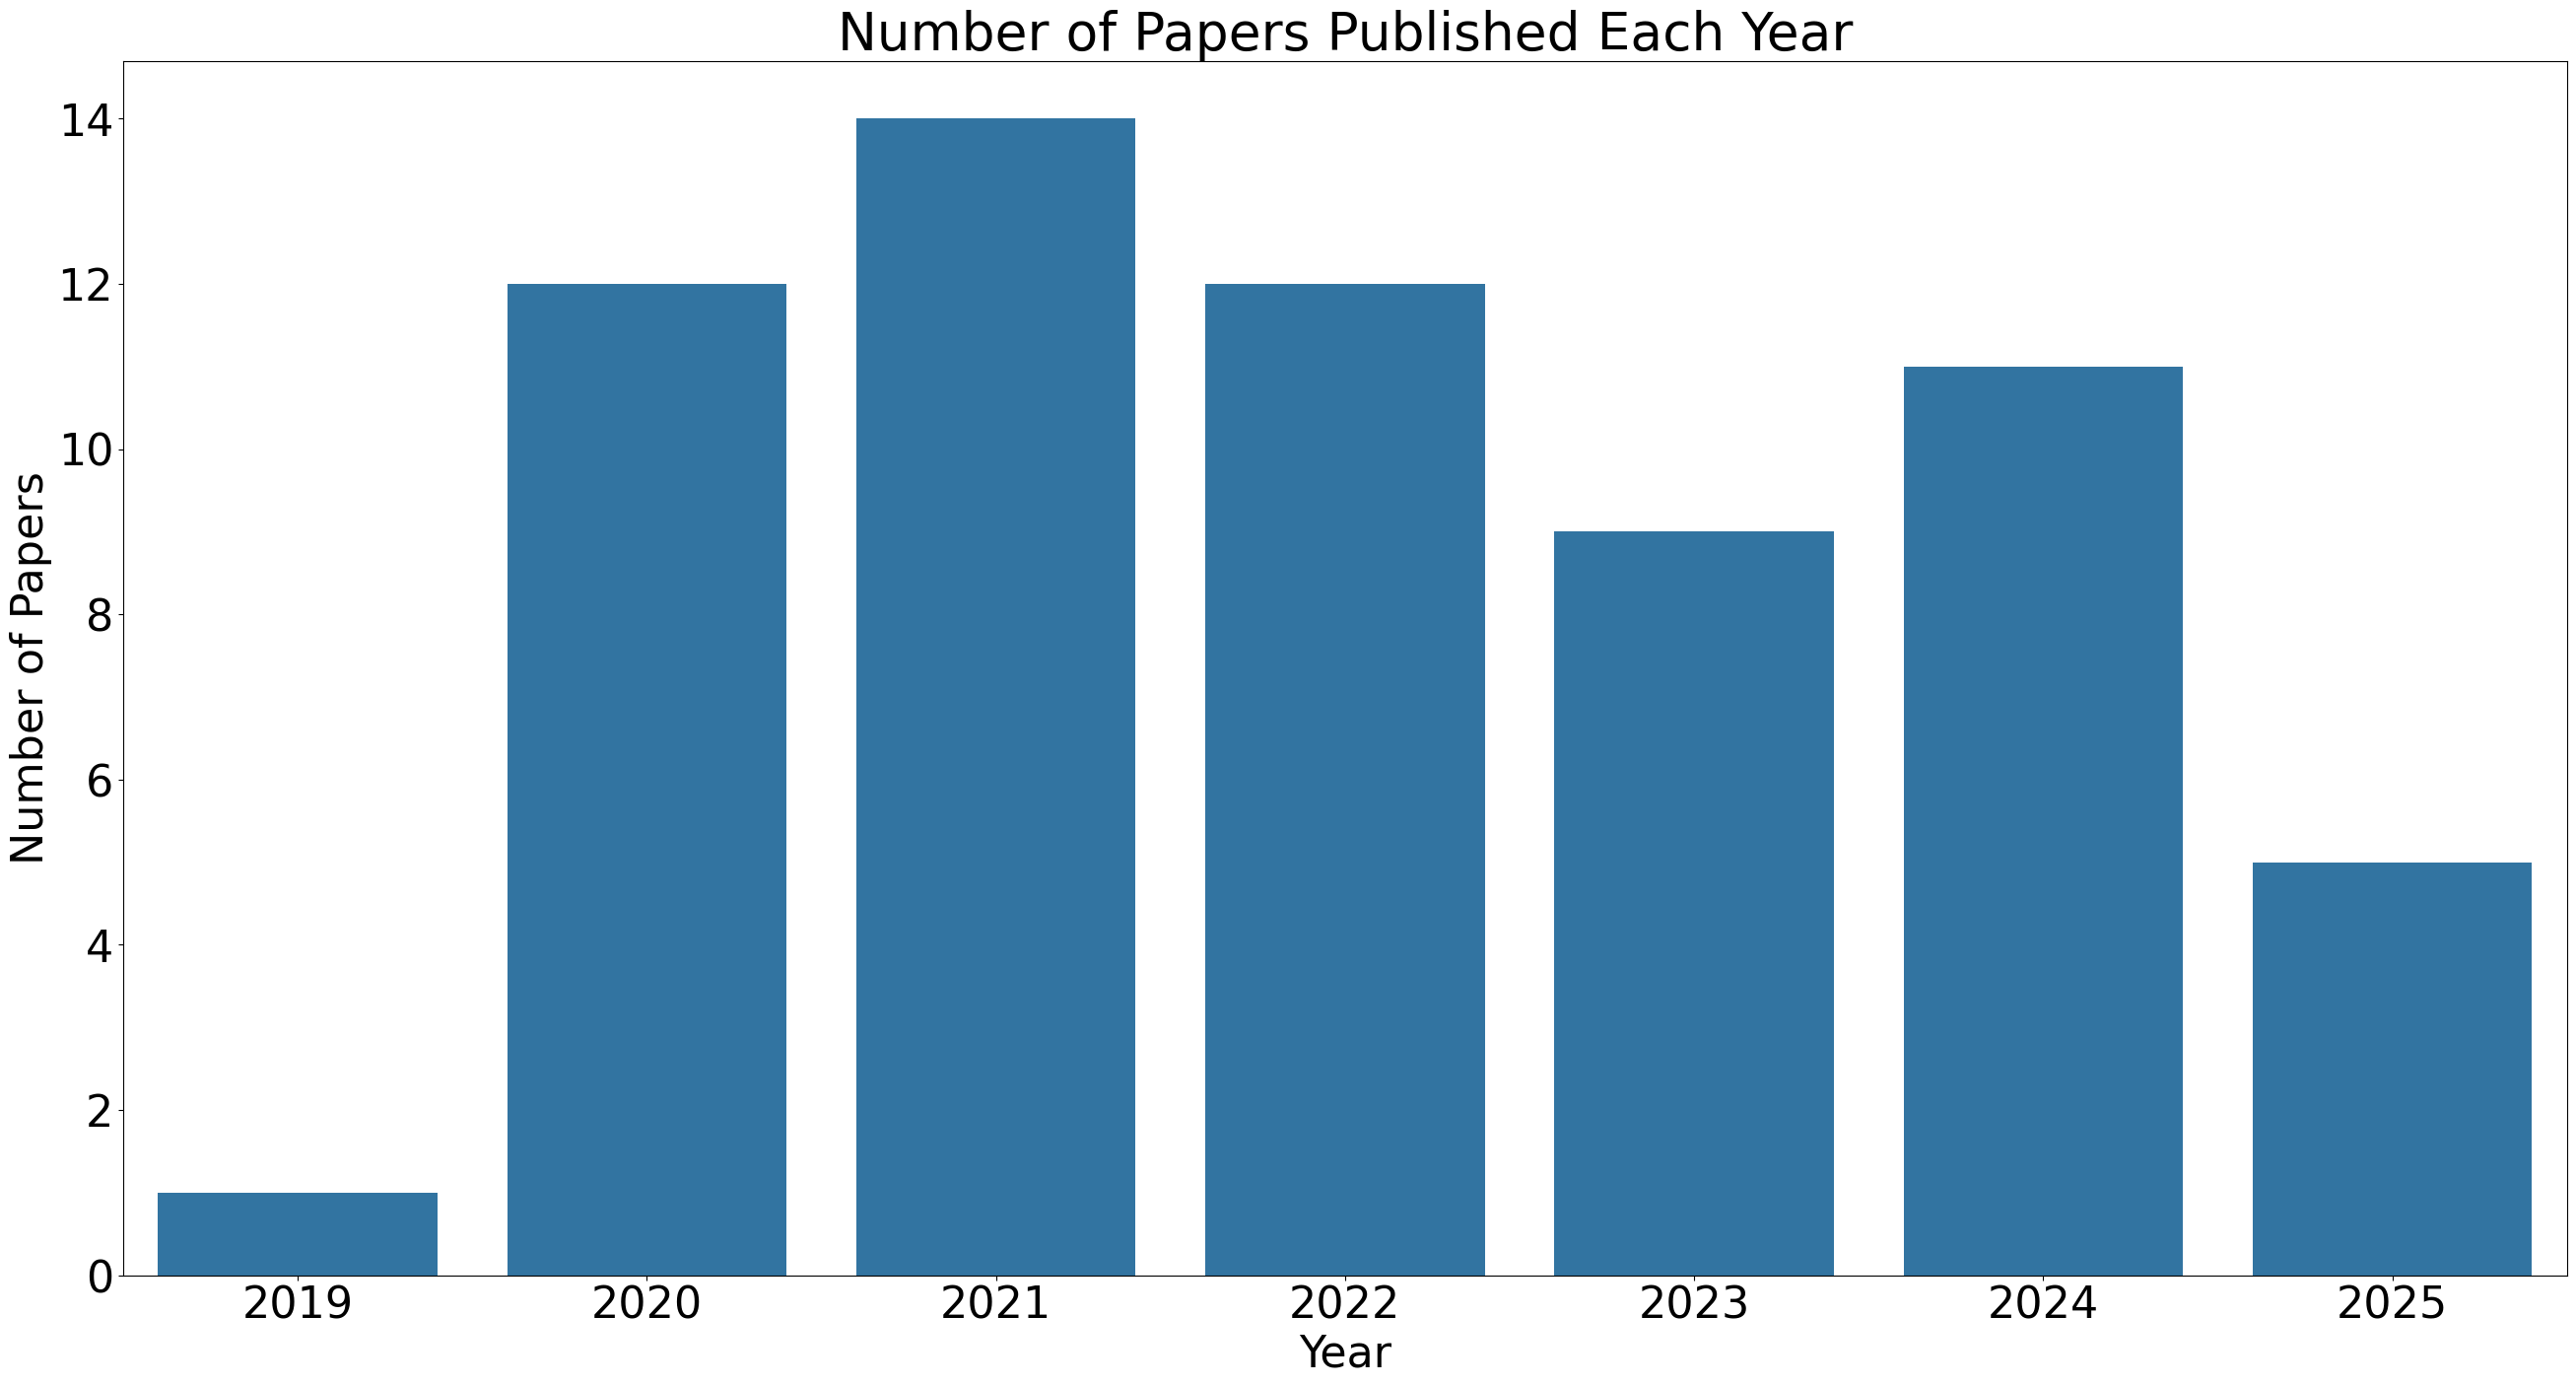

In [5]:
# Group by Year and count the number of papers
monthly_counts = df.groupby(['Year'], observed=False).size().reset_index(name='Counts')

# Create the plot
plt.rcParams.update({'font.size': 32})
plt.figure(figsize=(32, 16))

sns.barplot(data=monthly_counts, x='Year', y='Counts')

plt.title('Number of Papers Published Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.savefig('paper_by_year.svg', bbox_inches='tight')
plt.show()

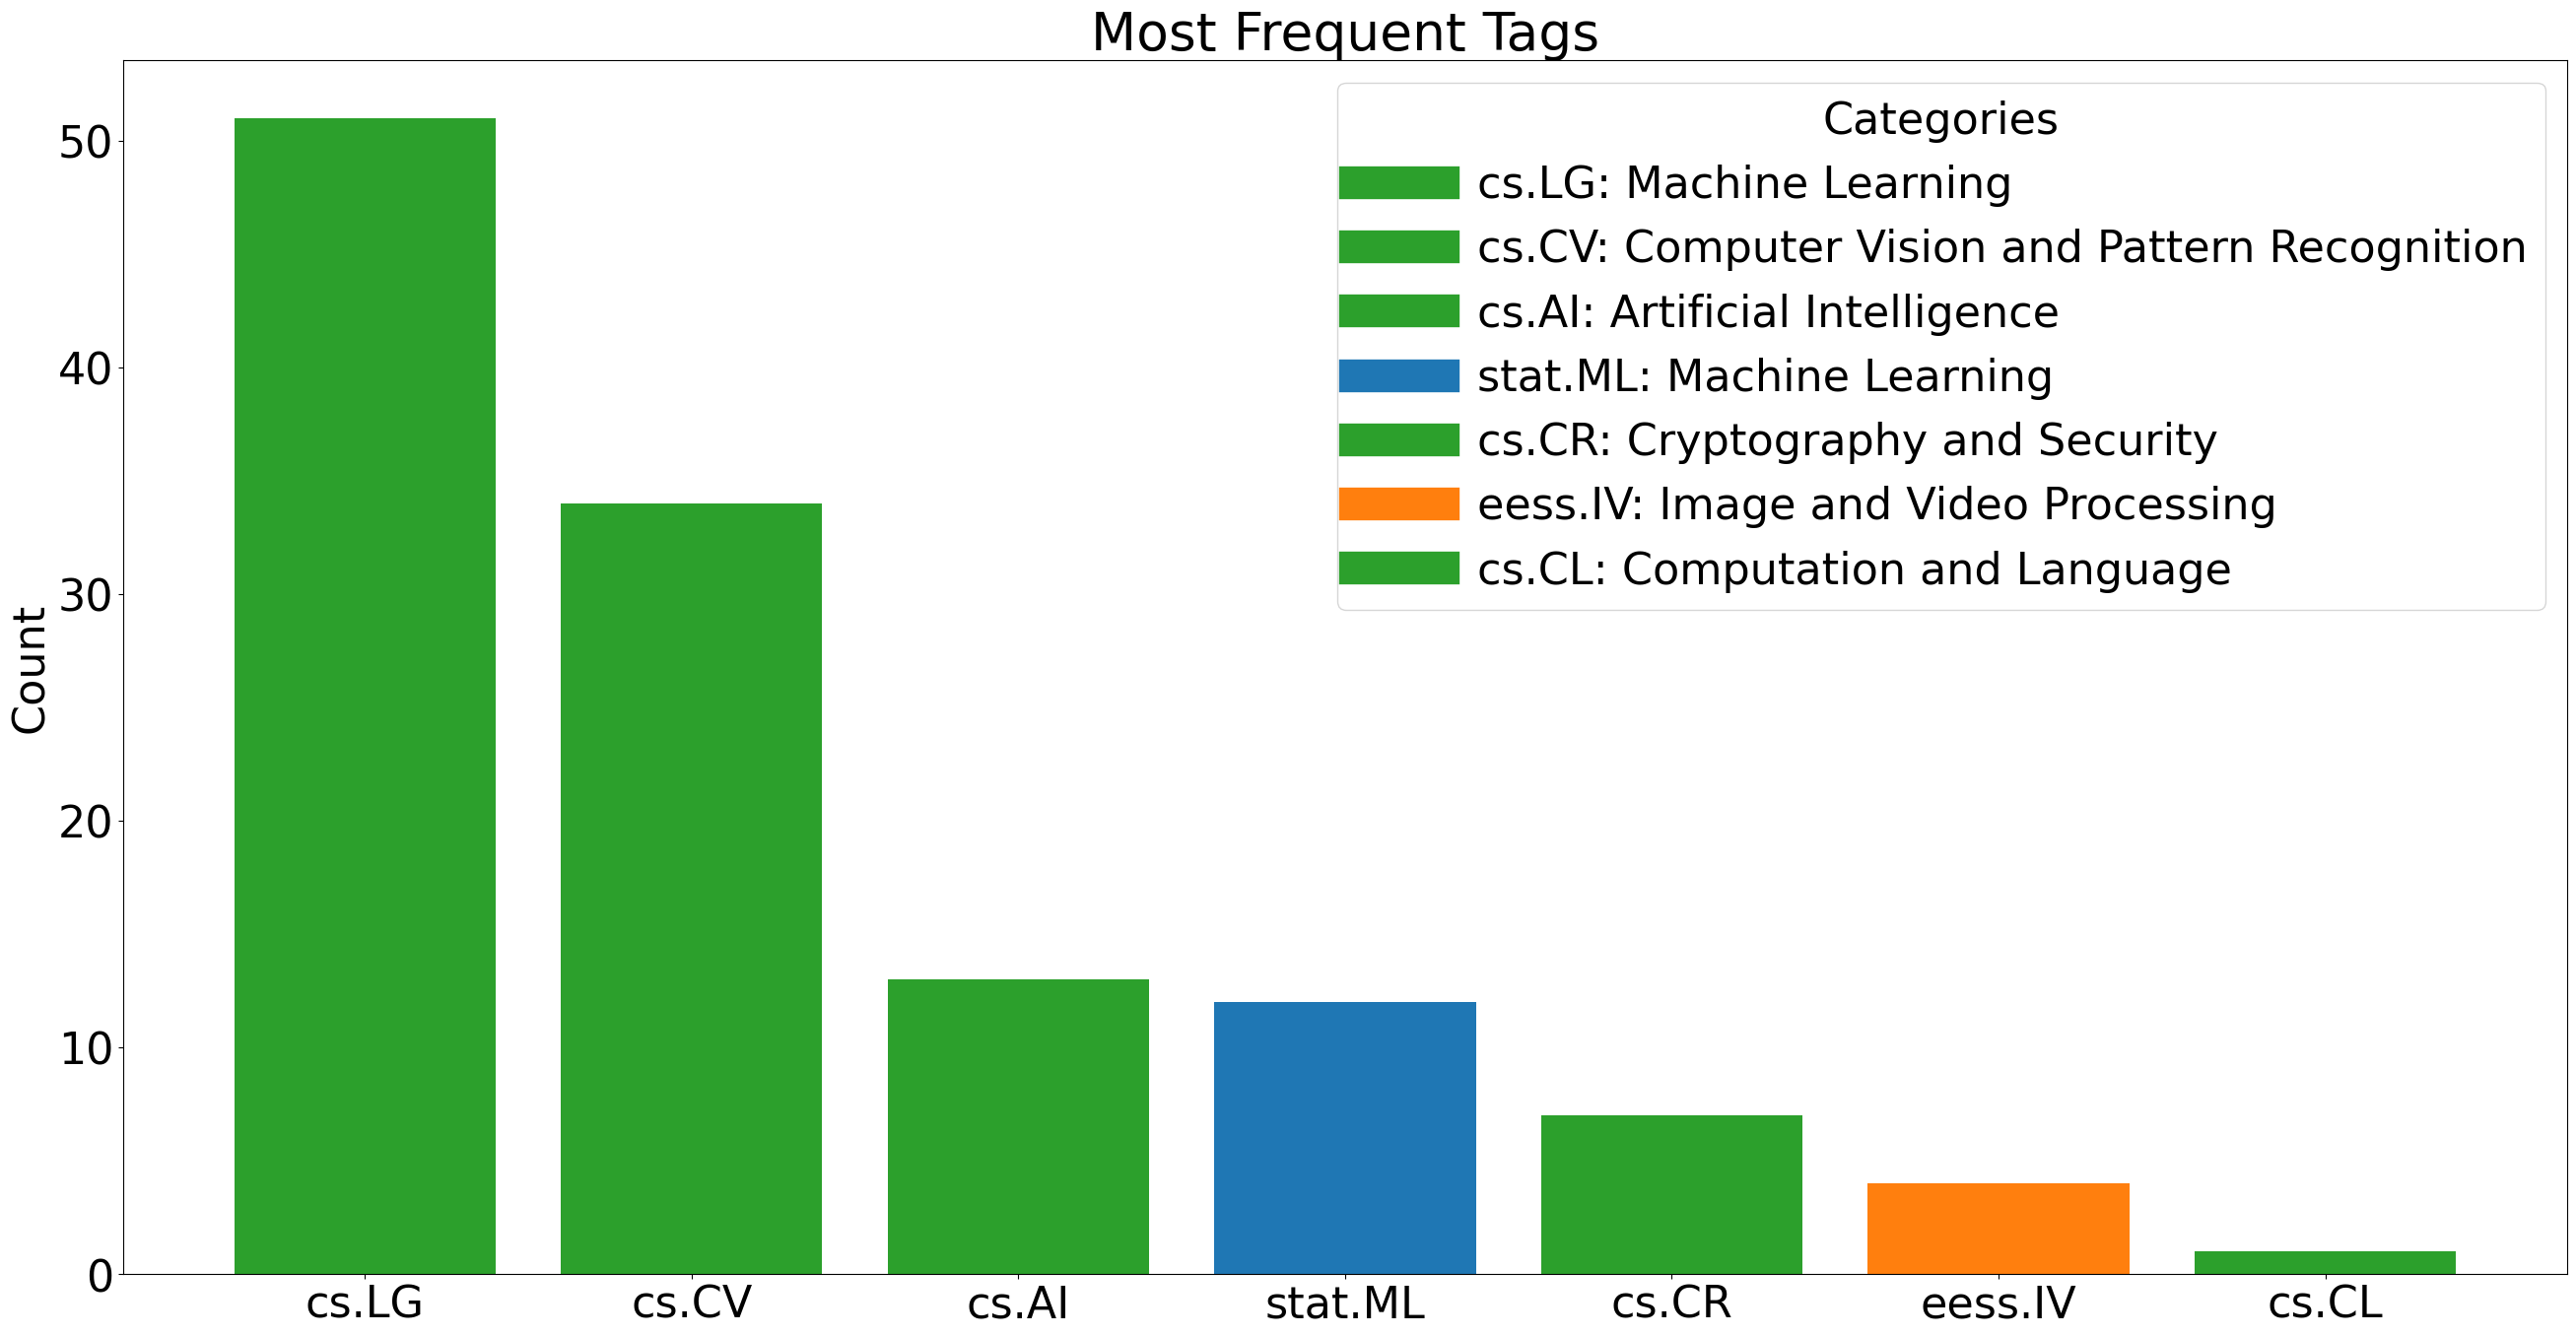

In [6]:
# @title Tags

freq = {}

for i in range(len(df)):
    tags = df.iloc[i]['Tag'].split(', ')
    for tag in tags:
        freq[tag] = freq.get(tag, 0) + 1

# Sort and get top values
freq = dict(sorted(freq.items(), key=lambda item: item[1], reverse=True))

# **Assign colors based on "x" (prefix of "x.y")**
x_prefix_map = {a.split('.')[0]: plt.cm.tab10(i % 10) for i, a in enumerate(set(a.split('.')[0] for a in freq.keys()))}
colors = [x_prefix_map[a.split('.')[0]] for a in freq.keys()]

# **Plot**
plt.figure(figsize=(32, 16))
plt.bar(freq.keys(), freq.values(), color=colors)
plt.title(f'Most Frequent Tags')
plt.ylabel("Count")

# **Filter legend to only plotted "a: b" pairs**
legend_items = {a + ': ' + tag_info[a]: x_prefix_map[a.split('.')[0]] for a in freq.keys()}

for label, color in legend_items.items():
    plt.plot([], [], color=color, label=label, linewidth=24)

plt.legend(title="Categories", loc="upper right")
plt.savefig("most_freq_tags.svg")
plt.show()

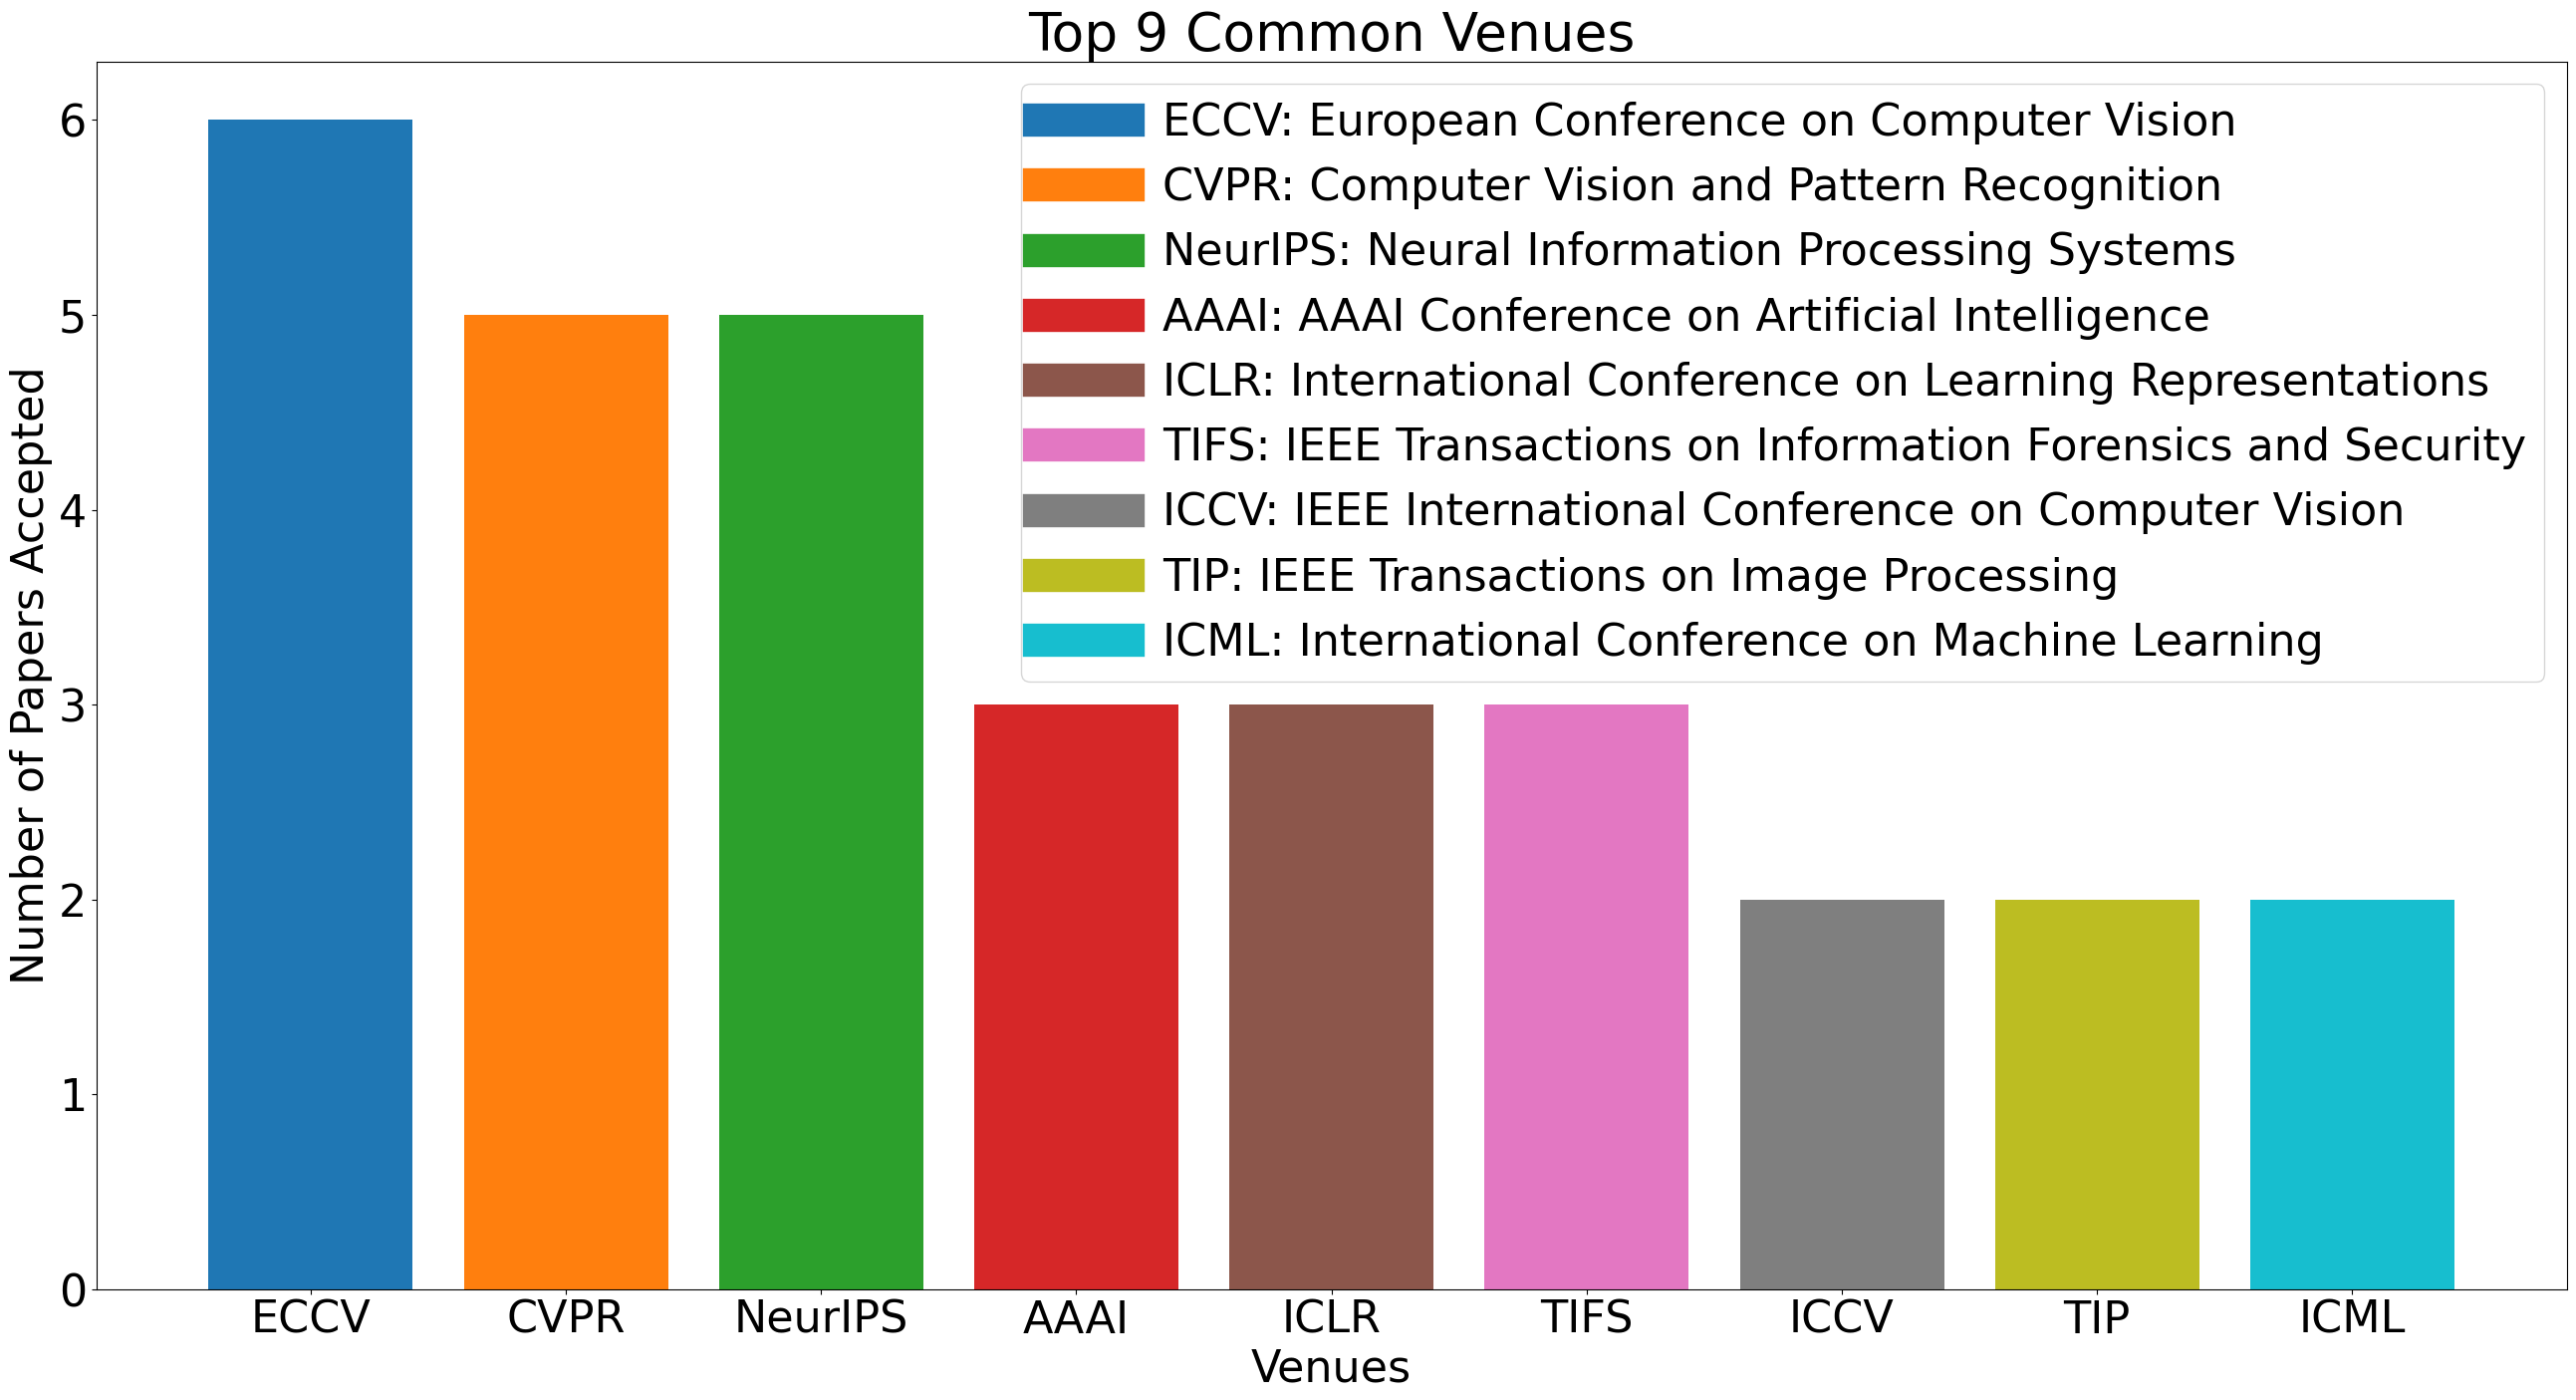

In [7]:
# @title Venues

freq = {}
for i in range(len(df)):
    venue = df.iloc[i]['Venue']
    if venue in freq:
        freq[venue] += 1
    else:
        freq[venue] = 1
freq['Unknown'] = 0
freq = dict(sorted(freq.items(), key=lambda item: item[1], reverse=True))

abbrev = {'Neural Information Processing Systems': 'NeurIPS',
          'International Conference on Learning Representations': 'ICLR',
          'International Conference on Machine Learning': 'ICML',
          'International Conference on Artificial Intelligence and Statistics': 'AISTATS',
          'Trans. Mach. Learn. Res.': 'TMLR', 'Journal of machine learning research': 'JMLR',
          'Computer Vision and Pattern Recognition': 'CVPR',
          'Annual Conference Computational Learning Theory': 'COLT',
          'Machine Learning: Science and Technology': 'MLST',
          'IEEE Transactions on Information Theory': 'IEEE Trans Inf Theory',
          'AAAI Conference on Artificial Intelligence': 'AAAI',
          'IEEE International Conference on Acoustics, Speech, and Signal Processing': 'ICASSP',
          'International Joint Conference on Artificial Intelligence': 'IJCAI',
          'European Conference on Computer Vision': 'ECCV',
          'IEEE Transactions on Information Forensics and Security': 'TIFS',
          'IEEE International Conference on Computer Vision': 'ICCV',
          'IEEE Transactions on Image Processing': 'TIP'}

# Get top venues and counts
top = 9
venues = list(freq.keys())[:top]
counts = list(freq.values())[:top]

# Use abbreviations for tick labels, defaulting to original name if missing
abbrev_labels = [abbrev.get(venue, venue) for venue in venues]

# Ensure wrapped labels fit x-axis spacing
wrapped_labels = [textwrap.fill(label, width=10) for label in abbrev_labels]

# Generate unique colors for each venue
color_map = plt.get_cmap("tab10", len(venues))  # Use a colormap with distinct colors
colors = [color_map(i) for i in range(len(venues))]  # Assign unique colors

# **Plot bar chart with matching colors**
plt.figure(figsize=(32, 16))
plt.bar(wrapped_labels, counts, color=colors)
plt.title(f'Top {top} Common Venues')
plt.xlabel("Venues")
plt.ylabel("Number of Papers Accepted")

# **Create legend with matching colors**
for i, (full_name, short_name) in enumerate(zip(venues, abbrev_labels)):
    plt.plot([], [], color=colors[i], label=f"{short_name}: {full_name}", linewidth=24)

plt.legend(loc="upper right")
plt.savefig("most_freq_venues.svg", bbox_inches='tight')
plt.show()

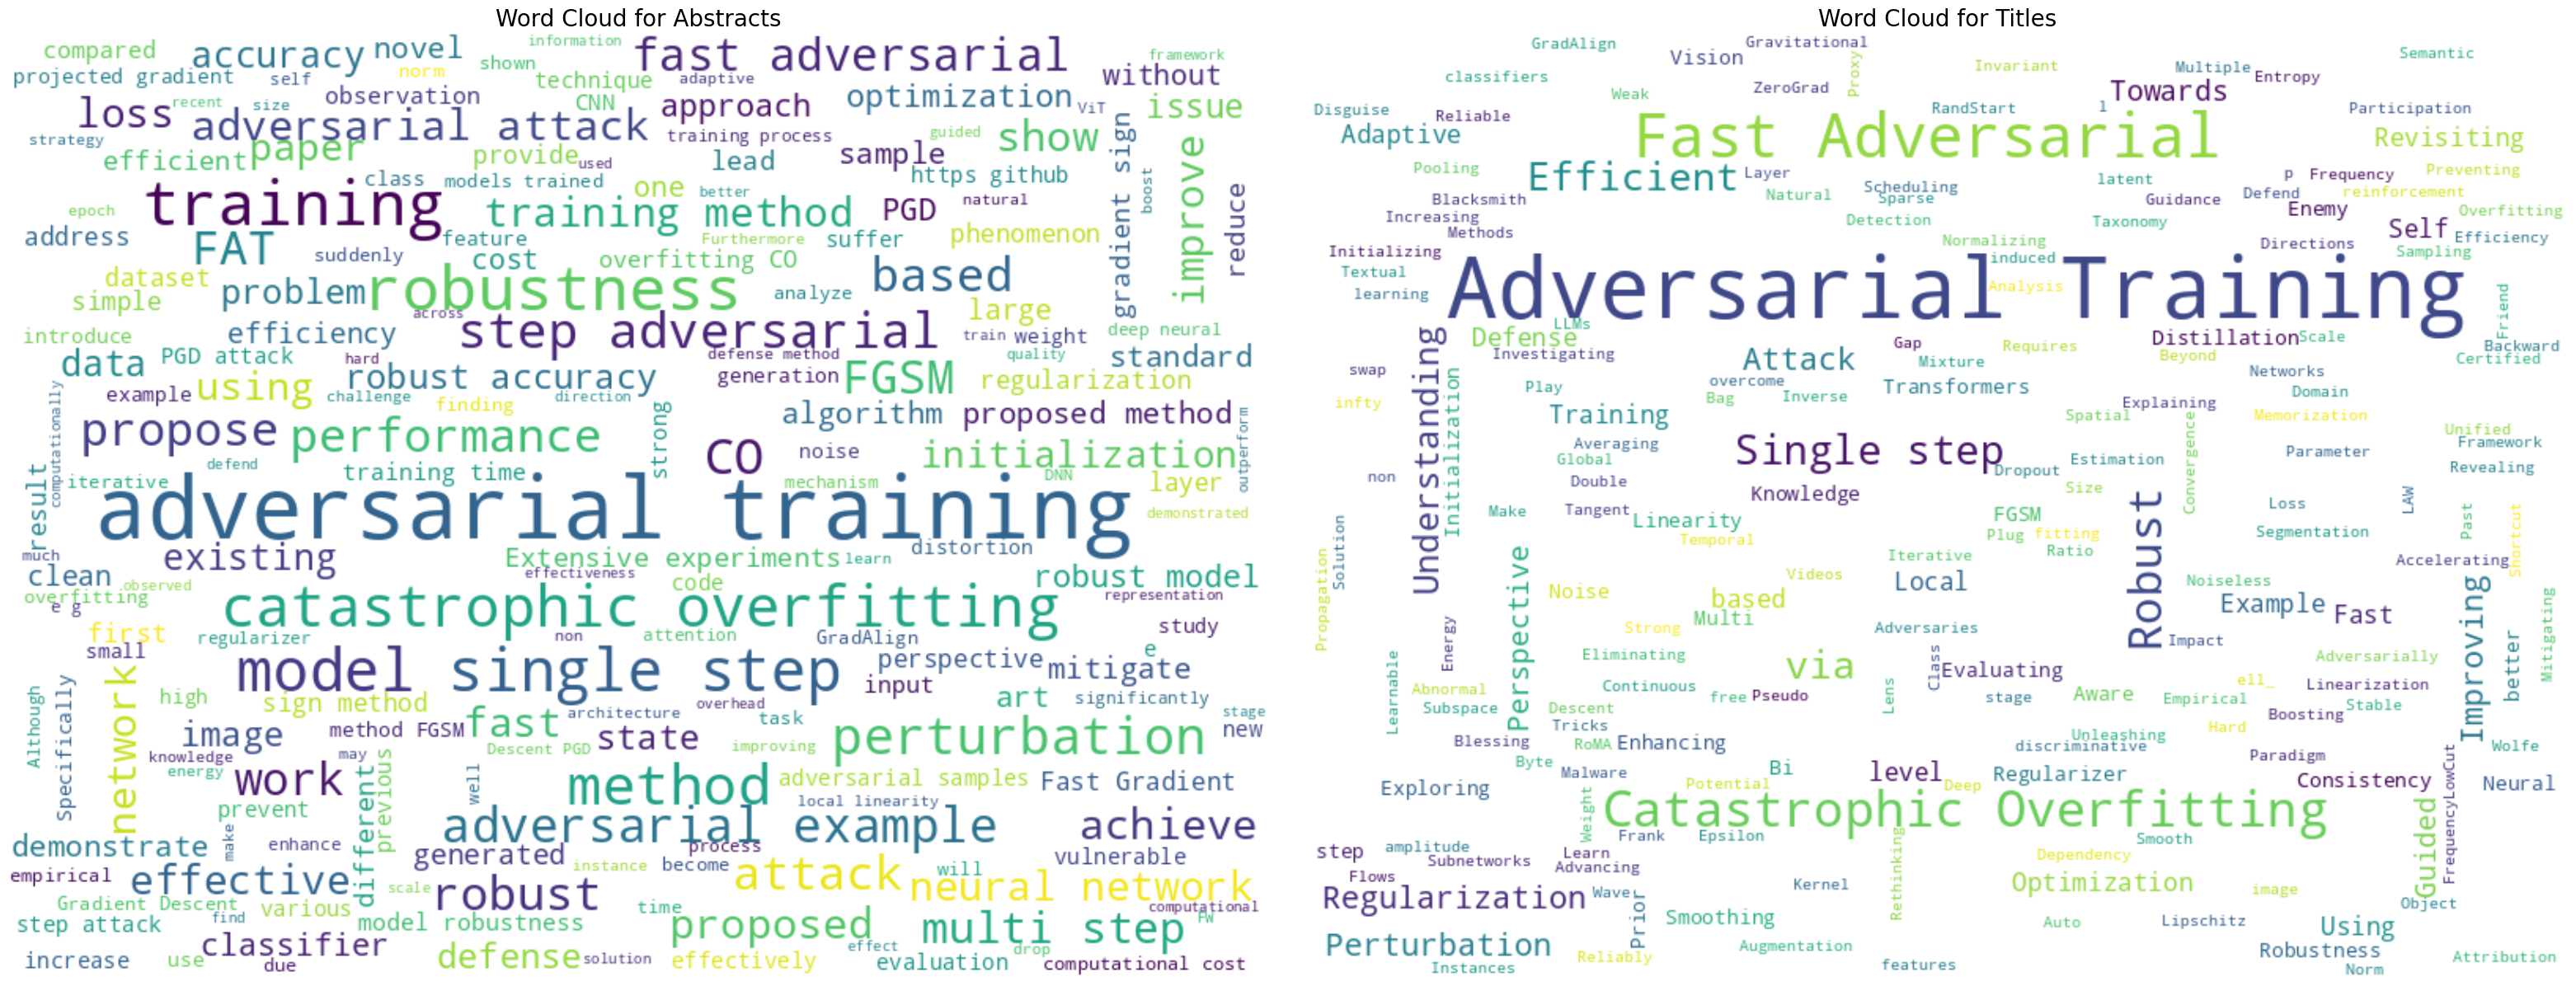

In [8]:
# @title Word Clouds

# Generate word cloud for abstracts
abstract_text = " ".join(df['Abstract'].dropna().tolist())
wordcloud_abstract = WordCloud(width=800, height=600, background_color='white').generate(abstract_text)

# Generate word cloud for titles
title_text = " ".join(df['Title'].dropna().tolist())
wordcloud_title = WordCloud(width=800, height=600, background_color='white').generate(title_text)

# Plot the word clouds
plt.figure(figsize=(32, 13))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_abstract, interpolation='bilinear')
plt.title('Word Cloud for Abstracts', fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_title, interpolation='bilinear')
plt.title('Word Cloud for Titles', fontsize=20)
plt.axis('off')

plt.tight_layout()
plt.savefig('word_clouds.png')
plt.show()

# README

In [9]:
# @title create read me file
def create_readme():
    year, month = None, None
    header = '# Catastrophic Overfitting Papers\nA complete list of papers on **Fast Adversarial Training** and **Catastrophic Overfitting** submitted to arXiv.\nYou can find the papers and their titles, abstracts, authors, links, and dates stored in [this csv file](https://github.com/RamtinMoslemi/Catastrophic-Overfitting-Papers/blob/main/co_papers.csv).\n\n'
    header += '## Paper Counts by Year\nNumber of papers submitted to arXiv by year.\n\n![yearly_papers](figures/paper_by_year.svg)\n\n'
    header += '## Word Clouds\nWord clouds of paper titles and abstracts.\n\n![word_clouds](figures/word_clouds.png)\n\n'
    header += '## Notebook\nYou can play with the notebook:\n\n'
    header += '[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RamtinMoslemi/Catastrophic-Overfitting-Papers/blob/main/CO_Papers.ipynb) [![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/RamtinMoslemi/Catastrophic-Overfitting-Papers/main/CO_Papers.ipynb)\n\n\n'
    with open('README.md', 'w', encoding='utf-8') as file:
        file.write(header)
        for i in range(len(df)):
            if df.iloc[i]['Year'] != year:
                year = df.iloc[i]['Year']
                file.write(f'# {year}\n')
            if df.iloc[i]['Month'] != month:
                month = df.iloc[i]['Month']
                file.write(f'## {month}\n')
            file.write(f"### [{df.iloc[i]['Title']}]({df.iloc[i]['Link']})\n\n")
            if len(df.iloc[i]['Authors'].split(',')) != 1:
                file.write(f"**Authors:**\n{df.iloc[i]['Authors']}\n\n")
            else:
                file.write(f"**Author:**\n{df.iloc[i]['Authors']}\n\n")
            if df.iloc[i]['Venue'] != 'Unknown':
                file.write(f"**Venue:**\n{df.iloc[i]['Venue']}\n\n")
            if df.iloc[i]['Citation Count'] != 0:
                file.write(f"**Citation Count:**\n{df.iloc[i]['Citation Count']}\n\n")
            file.write(f"**Abstract:**\n{df.iloc[i]['Abstract']}\n\n\n")

In [10]:
create_readme()

# Carlini

Searching papers from [A Complete List of All (arXiv) Adversarial Example Papers](https://nicholas.carlini.com/writing/2019/all-adversarial-example-papers.html) by [Nicholas Carlini](https://nicholas.carlini.com).

In [11]:
! gdown https://nicholas.carlini.com/writing/2019/advex_papers.json

Downloading...
From: https://nicholas.carlini.com/writing/2019/advex_papers.json
To: /content/advex_papers.json
20.3MB [00:00, 59.4MB/s]


In [12]:
import json
from tqdm.notebook import tqdm

def is_relevant(string, keys):
    for key in keys:
      if string.lower().find(key) != -1:
          return True
    return False

def get_co_papers(addr='advex_papers.json'):
    # Open and read the JSON file
    with open(addr, 'r') as file:
        data = json.load(file)
    # Find relevant papers
    keys = ['catastrophic overfitting', 'fast adversarial training',
            'single-step adversarial training', 'single-step defenses']
    co_papers = {'Date': [], 'Link': [], 'Title': [], 'Authors': [], 'Abstract': []}
    for paper in (pbar := tqdm(data[::-1])):
        if is_relevant(paper[2], keys) or is_relevant(paper[-1], keys):
            for idx, key in enumerate(co_papers):
                co_papers[key].append(paper[idx])
            pbar.set_description(f"Found {len(co_papers['Date'])} relevant papers")
    return pd.DataFrame(co_papers)

In [13]:
co_papers = get_co_papers()
search_results = [link.split('/')[-1] for link in df['Link']]

for paper in co_papers.iterrows():
    if paper[1]['Link'].split('/')[-1] not in search_results:
        print(paper[1]['Title'], paper[1]['Link'])

  0%|          | 0/12768 [00:00<?, ?it/s]

Possible false positives.

In [14]:
diff = 0

for i in range(min(len(df), len(co_papers))):
    if df.iloc[i]['Link'].split('/')[-1] != co_papers.iloc[i - diff]['Link'].split('/')[-1]:
        print(i, df.iloc[i]['Title'], df.iloc[i]['Link'])
        diff += 1

for i in range(min(len(df), len(co_papers)), len(df)):
    print(i, df.iloc[i]['Title'], df.iloc[i]['Link'])

12 Understanding and Increasing Efficiency of Frank-Wolfe Adversarial Training https://arxiv.org/abs/2012.12368
20 Adaptive perturbation adversarial training: based on reinforcement learning https://arxiv.org/abs/2108.13239
44 Learn from the Past: A Proxy Guided Adversarial Defense Framework with Self Distillation Regularization https://arxiv.org/abs/2310.12713
47 Rethinking Adversarial Training with Neural Tangent Kernel https://arxiv.org/abs/2312.02236
60 Fast Adversarial Training against Sparse Attacks Requires Loss Smoothing https://arxiv.org/abs/2502.21041
61 Fast Adversarial Training with Weak-to-Strong Spatial-Temporal Consistency in the Frequency Domain on Videos https://arxiv.org/abs/2504.14921
62 Catastrophic Overfitting, Entropy Gap and Participation Ratio: A Noiseless $l^p$ Norm Solution for Fast Adversarial Training https://arxiv.org/abs/2505.02360
63 Understanding Adversarial Training with Energy-based Models https://arxiv.org/abs/2505.22486


In [15]:
false_positives = ['https://arxiv.org/abs/2206.02355',
                   'https://arxiv.org/abs/2306.13185',
                   'https://arxiv.org/abs/2402.01297',
                   'https://arxiv.org/abs/2404.16612',
                   'https://arxiv.org/abs/2503.18998']